In [1]:
# Загружаем библиотеки
import pandas as pd # Датафреймы pandas
from sklearn.linear_model import LinearRegression # Линейная регрессия
from sklearn.model_selection import train_test_split # Разделение выборки на обучающую и тестовую
import matplotlib.pyplot as plt # Графики

#### Загрузка данных

In [2]:
# Загружаем датасет Сбербанка (цены на недвижимость)
# Используем следующие признаки
use_cols = ['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq',
'state', 'area_m', 'raion_popul', 'green_zone_part', 'indust_part', 'preschool_education_centers_raion',
'school_education_centers_raion', 'hospital_beds_raion', 'healthcare_centers_raion', 'sport_objects_raion',
'additional_education_raion', 'shopping_centers_raion', 'office_raion', 'ID_metro', 'metro_min_walk', 'kindergarten_km',
'school_km', 'park_km', 'green_zone_km', 'industrial_km', 'water_km', 'mkad_km', 'ttk_km', 'sadovoe_km', 'bulvar_ring_km',
'kremlin_km', 'ts_km', 'big_market_km','market_shop_km', 'fitness_km', 'university_km', 'workplaces_km', 'shopping_centers_km',
'office_km', 'additional_education_raion', 'preschool_km', 'price_doc']
data = pd.read_csv('train.csv', usecols = use_cols)

# Все результаты записываем в словарь
result = {}

#### Функция обучения модели и оценки её точности

In [3]:
# Функция принимает на вход массив признаков и вектор целевых значений
# Обучает линейную модель и возвращает оценки точности
def model_fit_score(X, y):
    # Разделение выборки на обучающую и тестовую
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)  
    # Вызываем модель линейной регрессии
    model = LinearRegression()
    # Обучаем модель на обучающей выборке
    model.fit(X_train, y_train)
    # Оцениваем качество с помощью коэффициента детерминации
    return model.score(X_test, y_test)

In [4]:
# Отбросим строки с пропусками
result['В исходном датасете отбросили все строки с пропусками'] = model_fit_score(data.dropna().iloc[:, :-1], data.dropna().iloc[:, -1])
print(f'Количество строк с пропусками {round((1 - len(data.dropna()) / len(data)) * 100)} % от всех значений')

Количество строк с пропусками 72 % от всех значений


#### Взаимная корелляция признаков

In [5]:
# Перебираем признаки попарно и считаем коэффициент корелляции
print('Следующие пары признаков имеют очень высокую корелляцию:')
for feature_1 in data.columns[:-1]:
    for feature_2 in data.columns[:-1]:
        corr = data[feature_1].corr(data[feature_2])
        if (abs(corr) > 0.9) & (feature_1 > feature_2):
            print(f'({feature_1} - {feature_2}) R = {round(corr, 2)}')


Следующие пары признаков имеют очень высокую корелляцию:
(school_education_centers_raion - preschool_education_centers_raion) R = 0.96
(school_km - preschool_km) R = 1.0
(park_km - metro_min_walk) R = 0.91
(ttk_km - sadovoe_km) R = 0.99
(ttk_km - bulvar_ring_km) R = 0.99
(ttk_km - kremlin_km) R = 0.98
(sadovoe_km - bulvar_ring_km) R = 1.0
(sadovoe_km - kremlin_km) R = 1.0
(kremlin_km - bulvar_ring_km) R = 1.0


Выделим группу признаков, относящихся к местоположению объекта недвижимости относительно центра Москвы:
- kremlin_km
- bulvar_ring_km
- sadovoe_km
- ttk_km

Информация в любом из них позволяет однозначно рассчитать значения оставшихся признаков с помощью карты.
Отбросим все, кроме kremlin_km

Пара признаков school_km - preschool_km имеет одинаковые значения, удалим preschool_km

Остальные сильно кореллированные признаки оставим без изменений

In [6]:
data.drop(['bulvar_ring_km', 'sadovoe_km', 'ttk_km', 'preschool_km'], axis = 1, inplace = True, errors = 'ignore')

In [7]:
result['Отбросили столбцы с коэффициентом корелляции 1'] = model_fit_score(data.dropna().iloc[:, :-1], data.dropna().iloc[:, -1])

#### full_sq и life_sq - общая и жилая площади

In [8]:
# Предположим, что общая площадь должна на 25 % превышать жилую
# Если общая площадь меньше 1,25 от жилой, то считаем это ошибкой, и перезаписываем такие значения
index = data[data['full_sq'] < (1.25 * data['life_sq'])].index
data.loc[index, 'full_sq'] = 1.25 * data.loc[index, 'life_sq']
# Найдём все строки, где общая площадь full_sq не превышает 10 м
# Предположим, что таких маленьких квартир не существует, поэтому удаляем эти строки
data.drop(data[data['full_sq'] < 10].index, inplace = True, errors = 'ignore')
# Найдём все строки, где общая площадь full_sq больше 1000 м
# Предположим, что таких больших квартир (или домов) не существует, поэтому удаляем эти строки
data.drop(data[data['full_sq'] > 1000].index, inplace = True, errors = 'ignore')

In [9]:
# В дальнейшем считаем, что стоимость квартир зависит в первую очередь от общей площади full_sq
# Отбросим признак life_sq
data.drop(['life_sq'], axis = 1, inplace = True, errors = 'ignore')

In [10]:
result['Заполнили пропуски и скорректировали выбросы признака full_sq, столбец life_sq отбросили'] = model_fit_score(data.dropna().iloc[:, :-1], data.dropna().iloc[:, -1])

#### floor и max_floor - этаж квартиры и количество этажей в доме

In [11]:
# Этаж квартиры сильнее влияет на стоимость, чем количество этажей в доме
# Кроме того, в признаке max_floor много пропусков
# поэтому признак max_floor можно отбросить
data.drop(['max_floor'], axis = 1, inplace = True, errors = 'ignore')
# Найдём все строки, где есть пропуски или floor = 0 и заполним их медианным значением признака floor
index = data[data['floor'].isna() | (data['floor'] == 0)].index
median = data['floor'].median()
data.loc[index, 'floor'] = median

In [12]:
result['Заполнили пропуски и скорректировали выбросы признака floor, столбец max_floor отбросили'] = model_fit_score(data.dropna().iloc[:, :-1], data.dropna().iloc[:, -1])

#### material - материал стен здания

In [13]:
# Признак категориальный, пропусков много, заполним их модой
index = data[data['material'].isna()].index
mode = data['material'].mode()[0]
data.loc[index, 'material'] = mode

In [14]:
result['Заполнили пропуски признака material'] = model_fit_score(data.dropna().iloc[:, :-1], data.dropna().iloc[:, -1])

#### build_year - год постройки

In [15]:
# Если год постройки не указан или меньше 1800 или больше 2017 (год публикации датасета)
# то для заполнения таких значений используем медиану столбца build_year 
index = data[data['build_year'].isna() | (data['build_year'] < 1800) | (data['build_year'] > 2017)].index
median = data['build_year'].median()
data.loc[index, 'build_year'] = median

In [16]:
result['Заполнили пропуски и скорректировали выбросы признака build_year'] = model_fit_score(data.dropna().iloc[:, :-1], data.dropna().iloc[:, -1])

#### num_room - количество жилых комнат

In [17]:
# Если количетсво комнат не указано, или равно нулю, или больше 5,
# то заполняем значения исходя из общей площади квартиры
# количество комнат = (0,75 * площадь) / 20 
# т.е в качестве жилой площади считаем 75 % от общей, а площадь 1 комнаты примем в среднем 20 м
index = data[data['num_room'].isna() | (data['num_room'] == 0) | (data['num_room'] > 5)].index
data.loc[index, 'num_room'] = round(0.75 * data.loc[index, 'full_sq'] / 20)

In [18]:
result['Заполнили пропуски признака num_room'] = model_fit_score(data.dropna().iloc[:, :-1], data.dropna().iloc[:, -1])

#### kitch_sq - площадь кухни

In [19]:
# Если площадь кухни не указана, или меньше 5, или больше 20,
# то для заполнения таких значений используем медиану
index = data[data['kitch_sq'].isna() | (data['kitch_sq'] < 5) | (data['kitch_sq'] >= 20)].index
median = data[data['kitch_sq'] >= 5]['kitch_sq'].median()
data.loc[index, 'kitch_sq'] = median

In [20]:
result['Заполнили пропуски признака kitch_sq'] = model_fit_score(data.dropna().iloc[:, :-1], data.dropna().iloc[:, -1])

#### state - состояние квартиры

In [21]:
# Признак порядковый
data['state'].value_counts()

2.0     5844
3.0     5787
1.0     4836
4.0      422
33.0       1
Name: state, dtype: int64

In [22]:
# Заменим пропущенные значения модой, а единственное значение 33 на 3
index = data[data['state'].isna()].index
mode = data['state'].mode()[0]
data.loc[index, 'state'] = mode
data.loc[data[data['state'] == 33].index, 'state'] = 3

In [23]:
result['Заполнили пропуски и скорректировали выбросы признака state'] = model_fit_score(data.dropna().iloc[:, :-1], data.dropna().iloc[:, -1])

#### area_m, raion_popul, green_zone_part, indust_part, preschool_education_centers_raion       

Пропуски:
area_m                               0
raion_popul                          0
green_zone_part                      0
indust_part                          0
preschool_education_centers_raion    0
dtype: int64


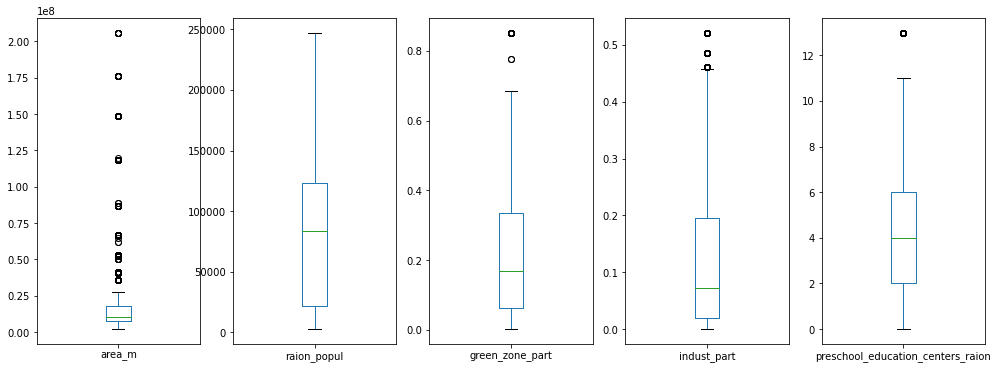

In [24]:
# Убеждаемся в отсутствии пропусков, смотрим диаграмму типа ящик с усами
# Значения этих признаков оставляем как есть
features = ['area_m', 'raion_popul', 'green_zone_part', 'indust_part', 'preschool_education_centers_raion']
data[features].plot(kind = 'box',
                    figsize=(17, 6),
                    subplots = True
                   )
print(f'Пропуски:\n{data[features].isna()[features].sum()}')

In [25]:
result['Признаки area_m, raion_popul, green_zone_part, indust_part, preschool_education_centers_raion без изменений'] = model_fit_score(data.dropna().iloc[:, :-1], data.dropna().iloc[:, -1])

#### hospital_beds_raion - количество коек в больницах района

In [26]:
# Пропущенные и нулевые значения заполним медианым значением
index = data[data['hospital_beds_raion'].isna() | (data['hospital_beds_raion'] == 0)].index
median = data['hospital_beds_raion'].median()
data.loc[index, 'hospital_beds_raion'] = median

In [27]:
result['Заполнили пропуски и скорректировали выбросы признака hospital_beds_raion'] = model_fit_score(data.dropna().iloc[:, :-1], data.dropna().iloc[:, -1])

#### healthcare_centers_raion, sport_objects_raion, additional_education_raion, shopping_centers_raion, office_raion

Пропуски:
healthcare_centers_raion      0
sport_objects_raion           0
additional_education_raion    0
shopping_centers_raion        0
office_raion                  0
dtype: int64


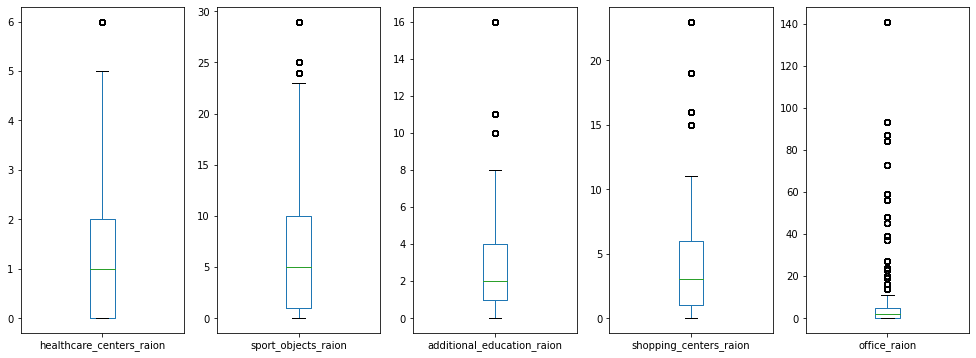

In [28]:
# Убеждаемся в отсутствии пропусков, смотрим диаграмму типа ящик с усами
# Значения этих признаков оставляем как есть
features = ['healthcare_centers_raion', 'sport_objects_raion', 'additional_education_raion', 'shopping_centers_raion', 'office_raion']
data[features].plot(kind = 'box',
                    figsize=(17, 6),
                    subplots = True
                   )
print(f'Пропуски:\n{data[features].isna()[features].sum()}')

In [29]:
result['Признаки healthcare_centers_raion, sport_objects_raion, additional_education_raion, shopping_centers_raion, office_raion без изменений'] = model_fit_score(data.dropna().iloc[:, :-1], data.dropna().iloc[:, -1])

#### ID_metro, metro_min_walk, kindergarten_km, school_km, park_km   

Пропуски:
ID_metro            0
metro_min_walk     25
kindergarten_km     0
school_km           0
park_km             0
dtype: int64


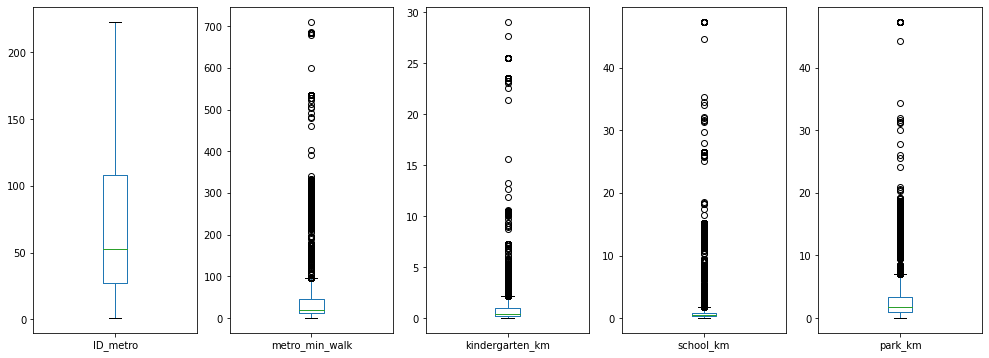

In [30]:
# Убеждаемся в отсутствии пропусков, смотрим диаграмму типа ящик с усами
# Пропуски и нулевые значения признака metro_min_walk заполняем медианным значением
# Остальные признаки без изменений
features = ['ID_metro', 'metro_min_walk', 'kindergarten_km', 'school_km', 'park_km']
data[features].plot(kind = 'box',
                    figsize=(17, 6),
                    subplots = True
                   )
print(f'Пропуски:\n{data[features].isna()[features].sum()}')

index = data[data['metro_min_walk'].isna() | (data['metro_min_walk'] == 0)].index
median = data['metro_min_walk'].median()
data.loc[index, 'metro_min_walk'] = median

In [31]:
result['Заполнили пропуски признака metro_min_walk, признаки ID_metro, kindergarten_km, school_km, park_km без изменений'] = model_fit_score(data.dropna().iloc[:, :-1], data.dropna().iloc[:, -1])

#### green_zone_km, industrial_km, water_km, mkad_km, kremlin_km

Пропуски:
green_zone_km    0
industrial_km    0
water_km         0
mkad_km          0
kremlin_km       0
dtype: int64


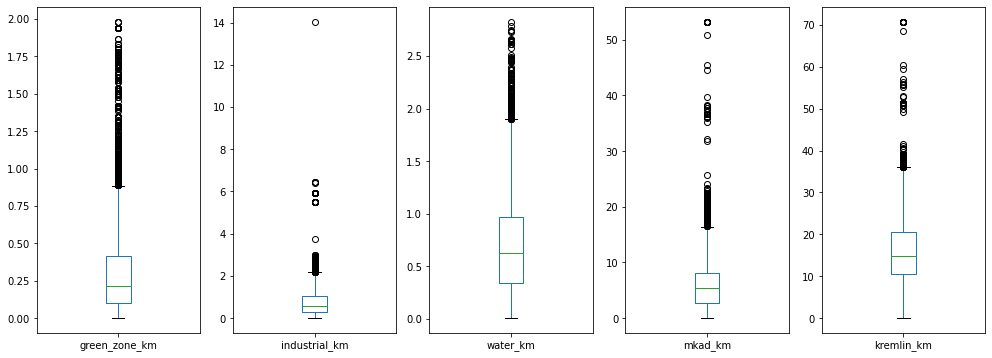

In [32]:
# Убеждаемся в отсутствии пропусков, смотрим диаграмму типа ящик с усами
# Значения этих признаков оставляем как есть
features = ['green_zone_km', 'industrial_km', 'water_km', 'mkad_km', 'kremlin_km']
data[features].plot(kind = 'box',
                    figsize=(17, 6),
                    subplots = True
                   )
print(f'Пропуски:\n{data[features].isna()[features].sum()}')

In [33]:
result['Признаки green_zone_km, industrial_km, water_km, mkad_km, kremlin_km без изменений'] = model_fit_score(data.dropna().iloc[:, :-1], data.dropna().iloc[:, -1])

#### ts_km, big_market_km, market_shop_km, fitness_km, university_km

Пропуски:
ts_km             0
big_market_km     0
market_shop_km    0
fitness_km        0
university_km     0
dtype: int64


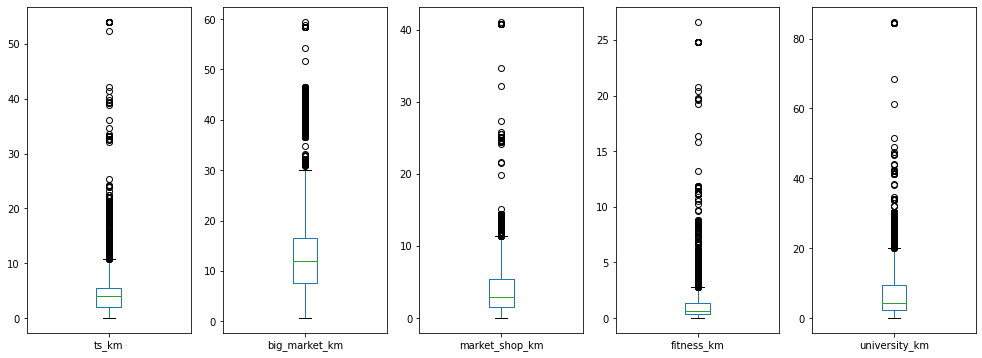

In [34]:
# Убеждаемся в отсутствии пропусков, смотрим диаграмму типа ящик с усами
# Значения этих признаков оставляем как есть
features = ['ts_km', 'big_market_km', 'market_shop_km', 'fitness_km', 'university_km']
data[features].plot(kind = 'box',
                    figsize=(17, 6),
                    subplots = True
                   )
print(f'Пропуски:\n{data[features].isna()[features].sum()}')

In [35]:
result['Признаки ts_km, big_market_km, market_shop_km, fitness_km, university_km без изменений'] = model_fit_score(data.dropna().iloc[:, :-1], data.dropna().iloc[:, -1])

#### workplaces_km, shopping_centers_km, office_km

Пропуски:
workplaces_km          0
shopping_centers_km    0
office_km              0
dtype: int64


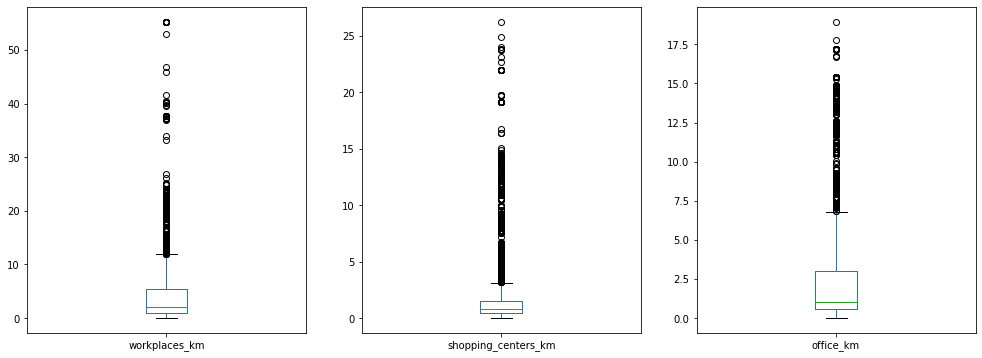

In [36]:
# Убеждаемся в отсутствии пропусков, смотрим диаграмму типа ящик с усами
# Значения этих признаков оставляем как есть
features = ['workplaces_km', 'shopping_centers_km', 'office_km']
data[features].plot(kind = 'box',
                    figsize=(17, 6),
                    subplots = True
                   )
print(f'Пропуски:\n{data[features].isna()[features].sum()}')

In [37]:
result['Признаки workplaces_km, shopping_centers_km, office_km без изменений'] = model_fit_score(data.dropna().iloc[:, :-1], data.dropna().iloc[:, -1])

#### Диаграммы рассеяния

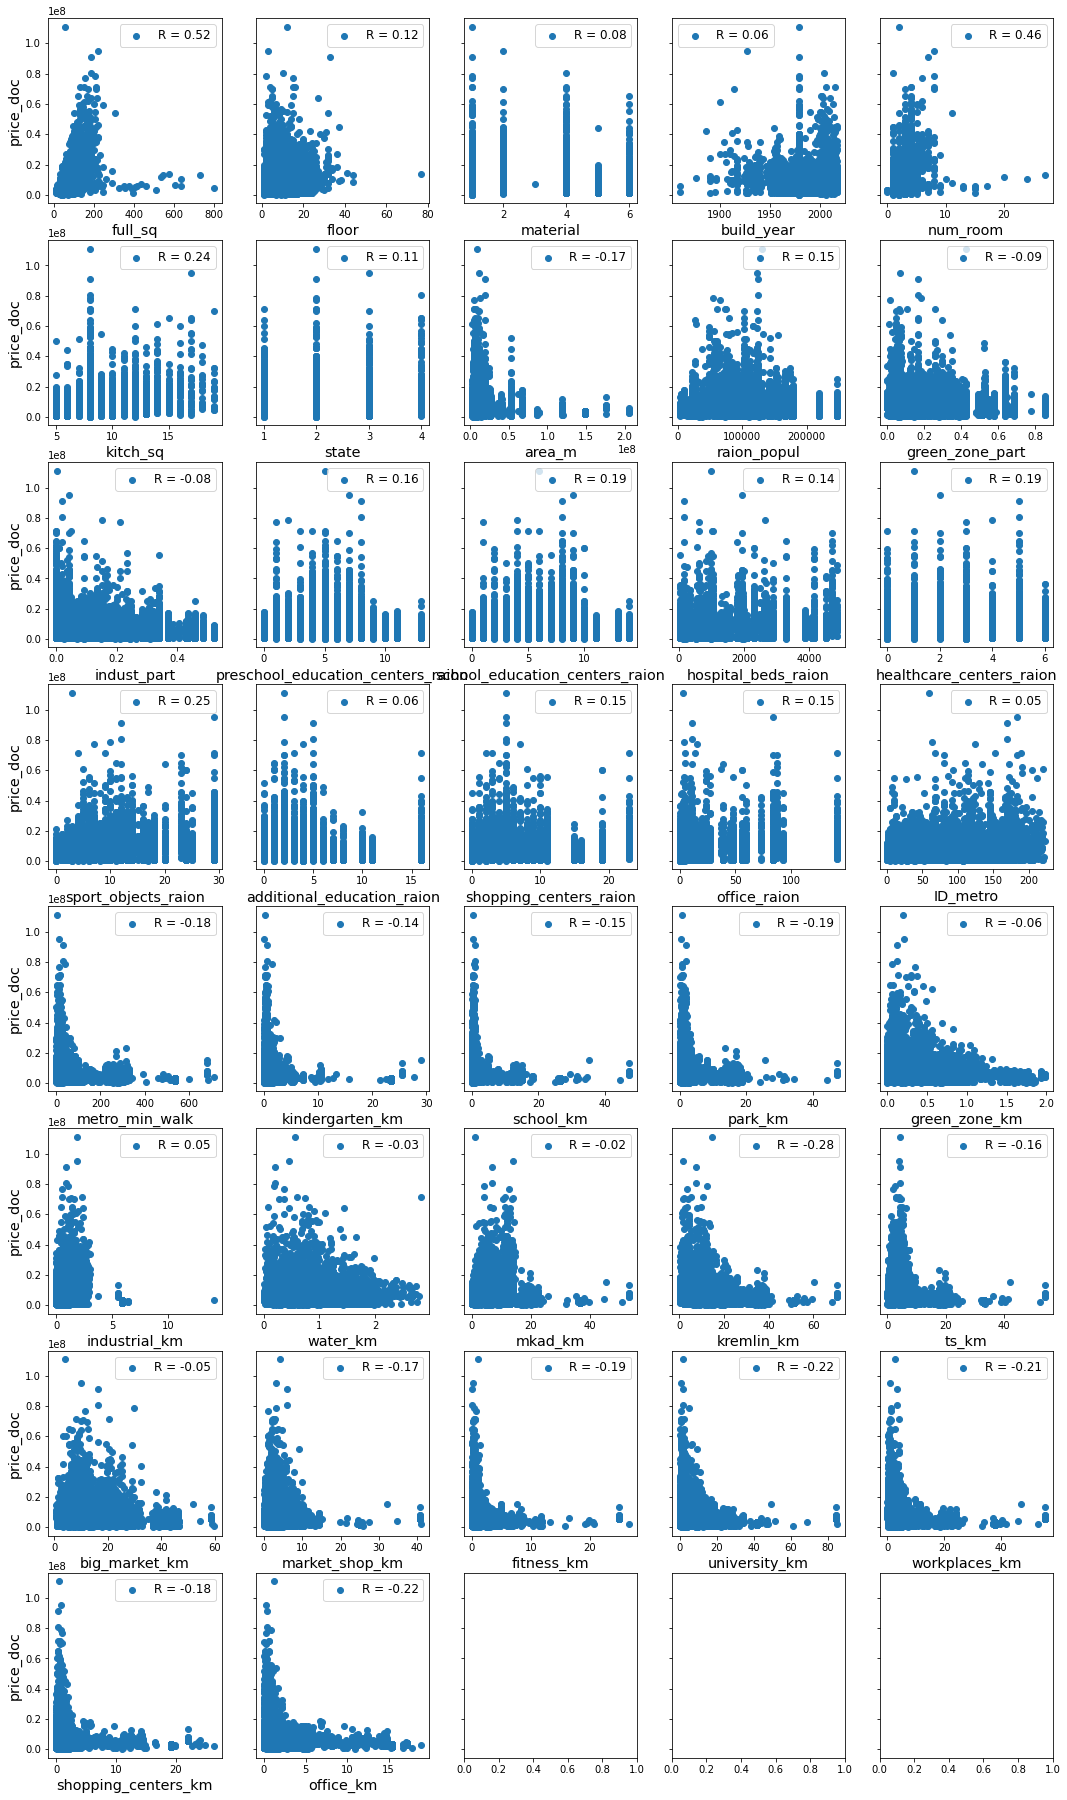

In [38]:
# Для анализа влияния признаков на целевые значения построим диаграммы рассеяния и посчитаем коэффициенты корелляции
fig, axes = plt.subplots(nrows = 8, # Столбцы
                         ncols = 5, # В строке 3 графика
                         figsize = (18, 32), # Размер общего поля
                         sharey = True # Ось У общая
                        ) 

for n in range(len(data.columns[:-1])):
    axes[n // 5, n % 5].scatter(x = data.iloc[:, n],
                                y = data.iloc[:, -1],
                                label = f'R = {round(data.iloc[:, n].corr(data.iloc[:, -1]), 2)}'
                               )
    axes[n // 5, n % 5].set_xlabel(data.columns[n], fontsize = 'x-large') 
    axes[n // 5, n % 5].legend(fontsize = 'large')
    axes[n // 5, 0].set_ylabel(data.columns[-1], fontsize = 'x-large')    
plt.show()

#### Создание новых признаков

По диаграммам рассеяния выбираем несколько признаков с зависимостью, похожей на квадратичную и наибольшим коэффициентом корелляции:
- kremlin_km (R = -0.28)
- office_km (R = -0.22)
- university_km (R = -0.22)
- workplaces_km (R = -0.21)
- park_km (R = -0.19)

In [39]:
# Создадим новые признаки
data['kremlin_km_2'] = data['kremlin_km'] ** 2
data['office_km_2'] = data['office_km'] ** 2
data['university_km_2'] = data['university_km'] ** 2
data['workplaces_km_2'] = data['workplaces_km'] ** 2
data['park_km_2'] = data['park_km'] ** 2
result['Добавлены квадратичные признаки kremlin_km_2, office_km_2, university_km_2, workplaces_km_2, park_km_2'] = model_fit_score(data.dropna().iloc[:, :-1], data.dropna().iloc[:, -1])

#### График изменения качества модели

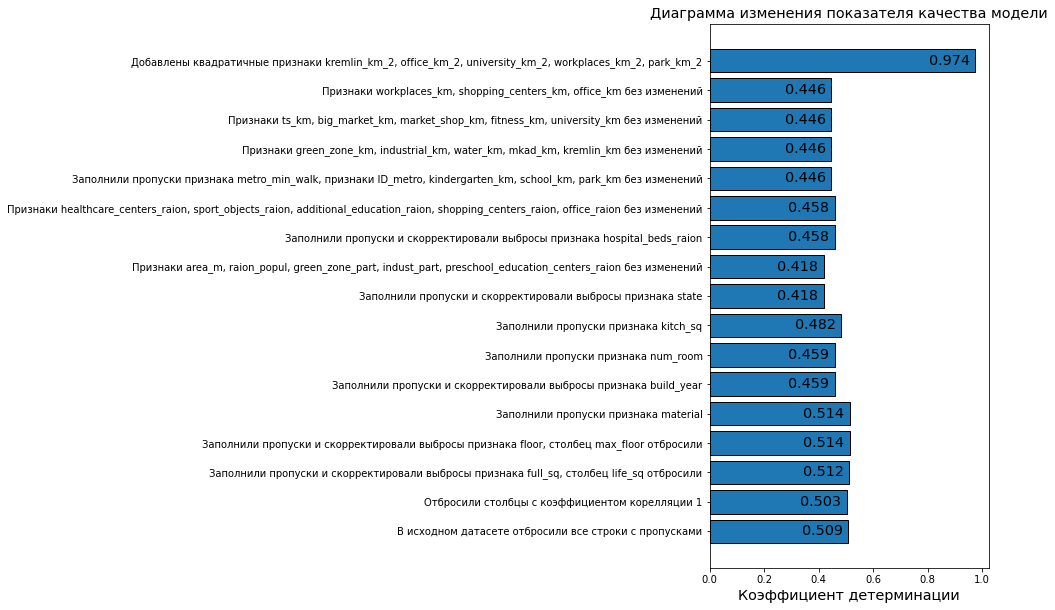

In [84]:
plt.figure(figsize = (5, 10))
plt.barh(list(result.keys()),
         list(result.values()),
         edgecolor = 'black',
         zorder = 2
        )
for i in list(result.keys()):
    plt.text(result[i] - 0.02, 
             i, 
             s = round(result[i], 3), 
             fontsize = 'x-large', 
             verticalalignment = 'center',
             horizontalalignment = 'right'
            )
plt.title('Диаграмма изменения показателя качества модели', fontsize = 'x-large')
plt.xlabel('Коэффициент детерминации', fontsize = 'x-large')
    
plt.show()

#### Выводы:
- в датасете 71 % строк с пропусками, необходимо их заполнить, иначе потеряем много информации
- несколько признаков дублируют друг друга, их можно отбросить не потеряв информацию
- создание новых признаков обеспечивает существенный прирост качества модели